# CelluScan 🧫

CelluScan is a deep learning model for classifying blood cells (mainly white blood cells) and detecting abnormalities.

This notebook demonstrates the full workflow:

- Data cleaning and balancing
- Data augmentation for minority classes
- Dataloader creation and splitting
- Model building (Vision Transformer)
- Training and evaluation

## Features

- **Multi-class blood cell classification**
- **Handles class imbalance** with augmentation
- **Easily extensible** for new cell types or abnormality detection

---


## 0. Imports & Color Codes

We import all required libraries for data handling, augmentation, and model building.

ANSI color codes are defined for improved terminal output readability.


In [1]:
import torch
import torchvision

from torch import nn
from torchvision import transforms
from going_modular.GPU_check import GPU_check

# ANSI escape codes for colors in Python
colors = {
    "reset": "\033[0m",

    # Regular Colors
    "black": "\033[30m",
    "red": "\033[31m",
    "green": "\033[32m",
    "yellow": "\033[33m",
    "blue": "\033[34m",
    "magenta": "\033[35m",
    "cyan": "\033[36m",
    "white": "\033[37m",

    # Bright Colors
    "bright_black": "\033[90m",
    "bright_red": "\033[91m",
    "bright_green": "\033[92m",
    "bright_yellow": "\033[93m",
    "bright_blue": "\033[94m",
    "bright_magenta": "\033[95m",
    "bright_cyan": "\033[96m",
    "bright_white": "\033[97m",

    # Background Colors
    "bg_black": "\033[40m",
    "bg_red": "\033[41m",
    "bg_green": "\033[42m",
    "bg_yellow": "\033[43m",
    "bg_blue": "\033[44m",
    "bg_magenta": "\033[45m",
    "bg_cyan": "\033[46m",
    "bg_white": "\033[47m",

    # Bright Backgrounds
    "bg_bright_black": "\033[100m",
    "bg_bright_red": "\033[101m",
    "bg_bright_green": "\033[102m",
    "bg_bright_yellow": "\033[103m",
    "bg_bright_blue": "\033[104m",
    "bg_bright_magenta": "\033[105m",
    "bg_bright_cyan": "\033[106m",
    "bg_bright_white": "\033[107m",

    # Styles
    "bold": "\033[1m",
    "dim": "\033[2m",
    "italic": "\033[3m",
    "underline": "\033[4m",
    "blink": "\033[5m",
    "reverse": "\033[7m",
    "hidden": "\033[8m"
}

device = GPU_check()
device

CUDA available: True
CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


'cuda'

## 1. Data Cleaning & Balancing

### Initial Class Distribution

| Class Name           | Count |
| -------------------- | ----- |
| Immature Granulocyte | 151   |
| Promyelocytes        | 592   |
| Myeloblast           | 1,000 |
| Metamyelocytes       | 1,015 |
| Myelocytes           | 1,137 |
| Erythroblast         | 1,551 |
| Band Neutrophil      | 1,634 |
| Basophil             | 1,653 |
| Platlets             | 2,348 |
| Segmented Neutrophil | 2,646 |
| Monocyte             | 5,046 |
| Neutrophil           | 6,779 |
| Eosinophil           | 7,141 |
| Lymphocyte           | 8,685 |

### Balancing Strategy

- **Target:** At least 4,500 samples per class
- **How:** Duplicate and augment (using `TrivialAugmentWide`) only for classes below the target
- **Result:** All classes will have at least 4,500 images, improving model robustness and reducing bias

The following code block performs this balancing and augmentation automatically.


In [6]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

from pathlib import Path
from PIL import Image
from tqdm import tqdm
import random

# Set paths
DATA_DIR = Path("Blood cells datasets/")
TARGET_COUNT = 4500 # Target minimum number of samples per class

# Define the augmentation transformation
augment_transform = transforms.TrivialAugmentWide()

# Load dataset
base_dataset = ImageFolder(root=DATA_DIR)
class_to_idx = base_dataset.class_to_idx # e.g., {"Basophil": 0, ...}

# Create a mapping from class index to class name
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Count current number of images in each class
from collections import defaultdict
class_counts = defaultdict(int) # Creates an empty dictionary to store image counts per class, initialized to 0.
for path, label in base_dataset.samples: # loop over every image and retrieves its label
    class_name = idx_to_class[label] # Convert label index to class name
    class_counts[class_name] += 1  # Increment count for that class

# Test print class counts
print (class_counts)
print(f"\n{colors['green']}[INFO] Starting augmentation...{colors['reset']}")


# Loop over classes and duplicate if needed
for class_name, count in class_counts.items():
    if count >= TARGET_COUNT:
        continue  # Already balanced

    folder_path = DATA_DIR / class_name
    images = list(folder_path.glob("*"))  # All image files in the class folder

    to_generate = TARGET_COUNT - count
    print(f"Augmenting {class_name}: current={count}, generating={to_generate}")

    for i in tqdm(range(to_generate)):
        # Randomly pick an existing image
        src_path = random.choice(images)
        with Image.open(src_path) as img:
            img = img.convert("RGB")  # ensure consistency
            augmented = augment_transform(img)

            # Create new file name
            base_name = src_path.stem
            new_filename = f"{base_name}_aug{i}.jpg"
            new_path = folder_path / new_filename

            # Save
            augmented.save(new_path)

print(f"\n{colors['blue']}[INFO]Augmentation complete. All classes now have at least 4,500 samples.{colors['reset']}")


defaultdict(<class 'int'>, {'Band Neutrophil': 3449, 'Basophil': 1653, 'Eosinophil': 7141, 'Erythroblast': 1551, 'Immature Granulocyte': 151, 'Lymphocyte': 8685, 'Metamyelocytes': 1015, 'Monocyte': 5046, 'Myeloblast': 1000, 'Myelocytes': 1137, 'Neutrophil': 6779, 'Platelets': 2348, 'Promyelocytes': 592, 'Segmented Neutrophil': 2646})

[INFO] Starting augmentation...
Augmenting Band Neutrophil: current=3449, generating=1051


100%|██████████| 1051/1051 [00:09<00:00, 113.39it/s]


Augmenting Basophil: current=1653, generating=2847


100%|██████████| 2847/2847 [00:22<00:00, 127.06it/s]


Augmenting Erythroblast: current=1551, generating=2949


100%|██████████| 2949/2949 [00:22<00:00, 132.86it/s]


Augmenting Immature Granulocyte: current=151, generating=4349


100%|██████████| 4349/4349 [00:13<00:00, 324.73it/s]


Augmenting Metamyelocytes: current=1015, generating=3485


100%|██████████| 3485/3485 [00:17<00:00, 202.56it/s]


Augmenting Myeloblast: current=1000, generating=3500


100%|██████████| 3500/3500 [00:17<00:00, 200.56it/s]


Augmenting Myelocytes: current=1137, generating=3363


100%|██████████| 3363/3363 [00:15<00:00, 212.41it/s]


Augmenting Platelets: current=2348, generating=2152


100%|██████████| 2152/2152 [00:19<00:00, 110.28it/s]


Augmenting Promyelocytes: current=592, generating=3908


100%|██████████| 3908/3908 [00:19<00:00, 198.90it/s]


Augmenting Segmented Neutrophil: current=2646, generating=1854


100%|██████████| 1854/1854 [00:20<00:00, 90.70it/s] 


[INFO]Augmentation complete. All classes now have at least 4,500 samples.


## 2. Dataloader Preparation

After balancing, we prepare the dataset for model training.

**Steps:**

1. Resize and transform images to a consistent shape
2. Split the dataset into training (80%) and testing (20%) sets
3. Create PyTorch dataloaders for efficient batch processing

This ensures the model receives well-structured and balanced data for both training and evaluation.


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

DATA_DIR = Path("Blood cells datasets/")

def create_dataloaders(root:Path,
                        transform: torchvision.transforms = None,
                        batch_size:int = 32):
    """
    Creates PyTorch DataLoaders for training and testing from an image folder dataset.

    Assumes that `root` contains subdirectories representing class names,
    with images inside each subdirectory.

    The dataset is split into 80% training and 20% testing. If no transform is 
    provided, a default transform is applied which resizes images to 224x224 
    and converts them to tensors.

    Args:
        root (Path): Path to the root directory of the dataset (should follow ImageFolder format).
        transform (torchvision.transforms, optional): A set of transformations to apply to the images.
                                                        If None, a default resize + ToTensor is used.
        batch_size (int): Number of samples per batch to load.

    Returns:
        train_dataloader (DataLoader): DataLoader for the training set.
        test_dataloader (DataLoader): DataLoader for the testing set.
        train_dataset (Dataset): Dataset for the training set.
        test_dataset (Dataset): Dataset for the testing set.
        class_names (list[str]): List of class names inferred from subdirectory names.
    """
    
    # Define a transform that resizes all images to the same shape
    if transform == None:
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])

    # Get dataset using ImageFolder
    dataset = datasets.ImageFolder(
        root= root,
        transform= transform
    )

    # Define train and test lengths (80% train, 20% test)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    # Random split dataset into train and test datasets
    train_dataset, test_dataset = random_split(dataset, lengths=[train_size, test_size])

    # Get dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle= False)

    # Get class names
    class_names = dataset.classes
    
    return train_dataloader, test_dataloader, train_dataset, test_dataset, class_names


train_dataloader, test_dataloader, train_dataset, test_dataset, class_names = create_dataloaders(root= DATA_DIR)
print (f"Training dataloader = {train_dataloader}")
print (f"Testing dataloader = {test_dataloader}")
print (f"Class names = {class_names},\nand their number = {len(class_names)}")

Training dataloader = <torch.utils.data.dataloader.DataLoader object at 0x00000207C701F910>
Testing dataloader = <torch.utils.data.dataloader.DataLoader object at 0x000002081B4D9960>
Class names = ['Band Neutrophil', 'Basophil', 'Eosinophil', 'Erythroblast', 'Immature Granulocyte', 'Lymphocyte', 'Metamyelocytes', 'Monocyte', 'Myeloblast', 'Myelocytes', 'Neutrophil', 'Platelets', 'Promyelocytes', 'Segmented Neutrophil'],
and their number = 14


### 2.1 Using a Subset for Fast Experimentation

For rapid prototyping and to avoid overfitting during early experimentation, we use only 5% of the data from each class.

This approach allows for faster training and debugging, especially with large datasets.

The function below samples 5% of each class and returns a corresponding dataloader.


In [14]:
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import random

def get_x_percent_dataloader(dataset: torch.utils.data.Dataset, 
                            percent: float,
                            batch_size:int =32, 
                            shuffle:bool =True,
                            seed:int =42) -> DataLoader:
    """
    Creates a DataLoader that contains a specified percentage of samples from each class 
    in the provided dataset.

    This function works with both full datasets (like ImageFolder) and Subsets. It 
    ensures that each class contributes approximately the same percentage of its data.

    Args:
        dataset (torch.utils.data.Dataset or torch.utils.data.Subset): 
            The dataset from which to sample (e.g., ImageFolder or a Subset).
        percent (float): 
            The percentage of samples to include per class (e.g., 0.1 for 10%).
        batch_size (int, optional): 
            Number of samples per batch in the returned DataLoader. Default is 32.
        shuffle (bool, optional): 
            Whether to shuffle the samples in the DataLoader. Default is True.
        seed (int, optional): 
            Random seed for reproducibility. Default is 42.

    Returns:
        DataLoader: A PyTorch DataLoader containing the selected subset of the dataset.
    """
    random.seed(seed)

    # Get true targets and indices from base dataset
    if isinstance(dataset, Subset):
        base_dataset = dataset.dataset
        base_indices = dataset.indices
        targets = [base_dataset.targets[i] for i in base_indices]
    else:
        base_dataset = dataset
        base_indices = list(range(len(dataset)))
        targets = base_dataset.targets
        

    # Group indices by class label
    class_to_idx = defaultdict(list)
    for base_idx, label in zip(base_indices, targets):
        class_to_idx[label].append(base_idx)

    # Sample x% of each class
    selected_indices = []
    for label, idxs in class_to_idx.items():
        n = max(1, int(percent * len(idxs)))
        selected_indices.extend(random.sample(idxs, n))

    # Create a subset and dataloader
    subset = Subset(base_dataset, selected_indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

    return dataloader



# Create dataloaders with 10% of the data in each class (to avoid dropouts)
train_dataloader_10_percent = get_x_percent_dataloader(dataset= train_dataset,
                                                        percent= 0.1,
                                                        batch_size= 32,
                                                        shuffle= True)

test_dataloader_10_percent = get_x_percent_dataloader(dataset= test_dataset,
                                                    percent= 0.1,
                                                    batch_size= 32,
                                                    shuffle= False)

train_dataloader_10_percent, test_dataloader_10_percent

(<torch.utils.data.dataloader.DataLoader at 0x207c6e7a710>,
 <torch.utils.data.dataloader.DataLoader at 0x207c6e7b8b0>)

In [4]:
# Inspect one batch
images_batch, labels_batch = next(iter(train_dataloader_10_percent))
test_img = images_batch[0]

images_batch.shape, labels_batch.shape, test_img.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]), torch.Size([3, 224, 224]))

## 3. Model Building: Vision Transformer (ViT)

We build a Vision Transformer (ViT) model, following the architecture from ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale."](https://arxiv.org/abs/2010.11929).

To use PyTorch's pretrained weights, our model must match the official architecture and naming conventions.

We'll first build each block independently for clarity and understanding, then assemble the full model.

**Helpful resources:**

- [ViT: Vision Transformer, by Shivani Junawane](https://medium.com/machine-intelligence-and-deep-learning-lab/vit-vision-transformer-cc56c8071a20)
- [Zero to Mastery Learn PyTorch for Deep Learning, chapter 08: PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/)


### 3.0 Key Diagrams and Equations

**Main model architecture:**

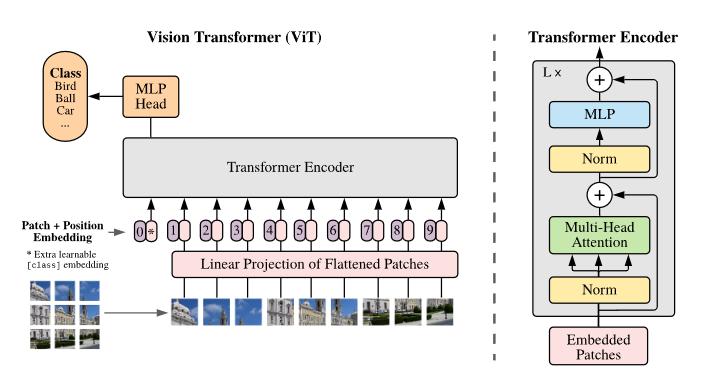

**Key equations:**

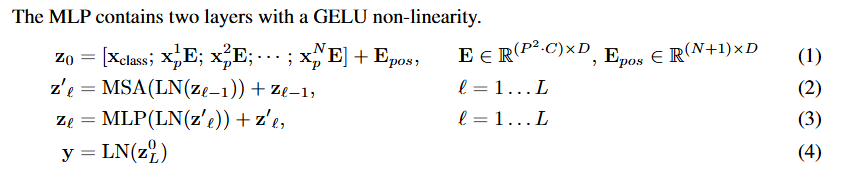

**Variables:**

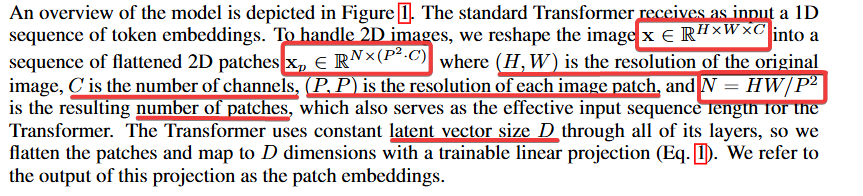
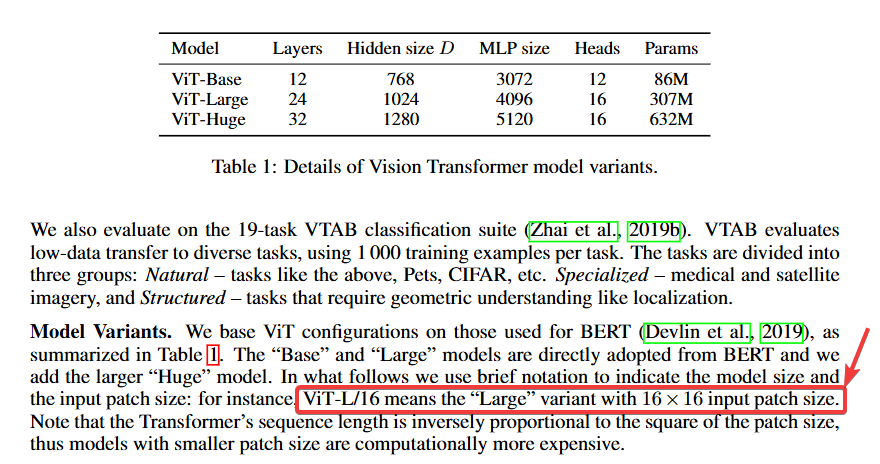


In [3]:
# First let's init all hyper parameters
HYPER_PARAMS = {"batch_size": 32, 
                "height": 224, # H
                "width" : 224, # W
                "color_channels": 3, # C
                
                "patch_size": 16, # P
                "number_of_patches": 224*224 // 16**2, # N = H*W/P^2
                "embedding_dim": 768, # D = N*(P^2 *C)
                
                "MLP_size": 3072,
                "num_heads": 12,
                
                "num_classes": 14
}

### 3.1 Embedding Layer

This layer consists of:

1. Patch embedding
2. Class token
3. Position embedding

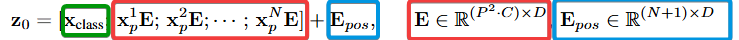


#### 3.1.1 Patch Embedding

Converts a 2D input image into a 1D sequence of learnable embedding vectors.


In [20]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self, in_channels: int = HYPER_PARAMS['color_channels'],
                        patch_size: int = HYPER_PARAMS['patch_size'],
                        embedding_dim: int = HYPER_PARAMS['embedding_dim']):
        super().__init__()

        self.patch_size = patch_size  # Store patch size for validation during forward pass

        # Step 1: Create a convolutional layer to divide the image into non-overlapping patches
        # Each patch is projected to a vector of size 'embedding_dim'
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

        # Step 2: Flatten the spatial dimensions (height and width) of the output from the patcher
        # This turns the image into a sequence of patch embeddings
        self.flatten = nn.Flatten(start_dim=2, end_dim=3) # [batch_size, embedding_dim, num_patches_h, num_patches_w]

    def forward(self, x):
        # Step 3: Get the image resolution (assuming square images)
        img_resolution = x.shape[-1]

        # Step 4: Ensure the image size is divisible by the patch size (no partial patches)
        assert img_resolution % self.patch_size == 0, \
            f"Input image size must be divisible by patch size, image shape: {img_resolution}, patch size: {self.patch_size}"

        # Step 5: Apply the patch embedding conv layer and flatten the result
        x_output = self.flatten(self.patcher(x))

        # print(x_output.shape)  # Debugging: print shape after patching and flattening

        # Step 6: Rearrange dimensions from [batch, embedding_dim, num_patches]
        # to [batch, num_patches, embedding_dim] to match expected input format
        return x_output.permute(0, 2, 1)


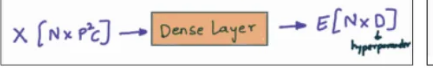


In [21]:
# Testing all shapes are correct
print(f"Input image shape: {test_img.unsqueeze(0).shape}") # BATCH, C, H, W

# Pass a single image through
patched_img = PatchEmbedding()

patch_embedded_image = patched_img(test_img.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


#### 3.1.2 Class Token

A learnable parameter prepended to the patch sequence, shared across all samples in the batch.

Shape after addition: `[batch_size, num_patches + 1, embedding_dim]`.

The class token is expanded to match the batch size in the forward pass.


In [ ]:
# Creating a single trainable parameter to act as the class token
class_token = nn.Parameter(torch.randn(1, 1, HYPER_PARAMS['embedding_dim']), 
                            requires_grad= True)

#### 3.1.3 Position Embedding

Adds positional information to the patch embeddings, allowing the transformer to retain spatial order.

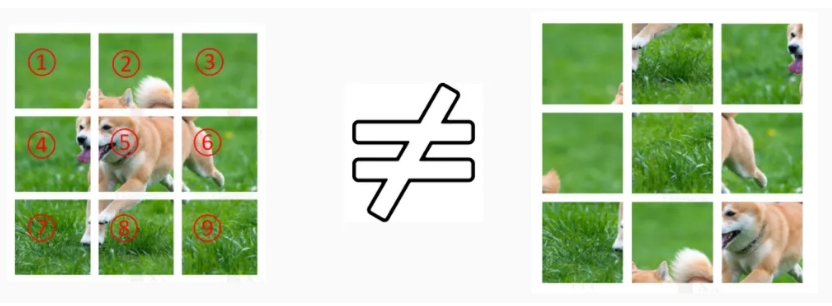


In [ ]:
# Create position embedding
position_embedding = nn.Parameter( # Same shape as the output of concating the cass token and the patch embedding 
                                torch.randn(1, HYPER_PARAMS['number_of_patches']+1, HYPER_PARAMS['embedding_dim']),
                                requires_grad= True)

### 3.2 Transformer Encoder Block

Implements the core transformer encoder block as described in [Attention Is All You Need](https://arxiv.org/pdf/1706.03762).

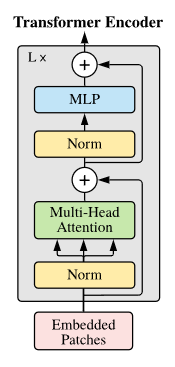


#### 3.2.1 Multi-Head Self Attention


Implements scaled dot-product attention with multiple heads.

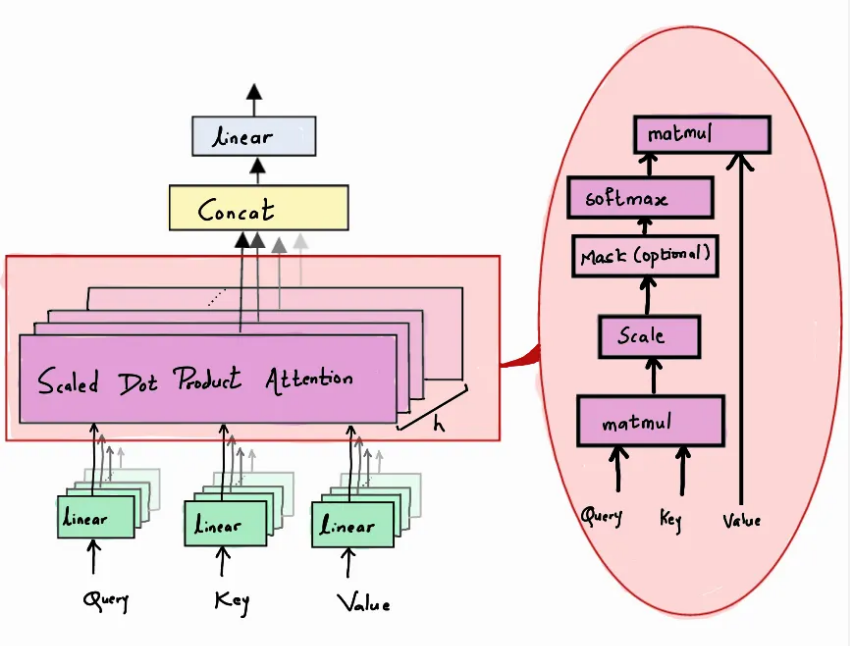

The main component is the **Scaled Dot-Product Attention**. Queries, keys, and values are computed, attention scores are calculated, and the output is a weighted sum of values.

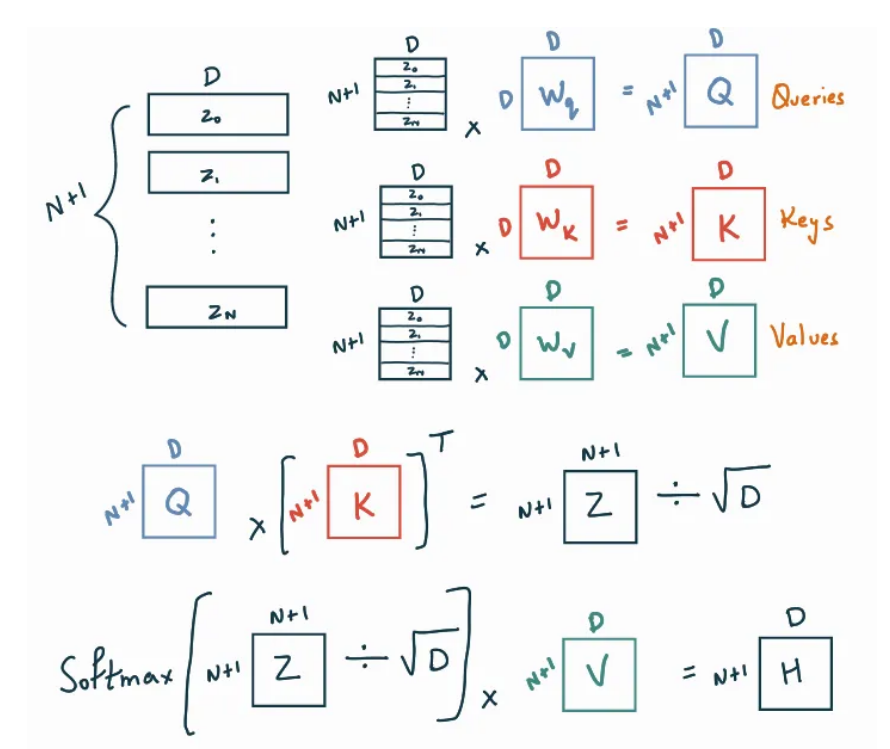


In [ ]:
import torch
from torch import nn
import math

class MSA(nn.Module):
    """
    Multi-Head Self-Attention (MSA) module.
    
    Args:
        hidden_dim (int): Input and output dimension (usually equal to embedding dim).
        num_heads (int): Number of attention heads to split input into.
    """
    def __init__(self, 
                hidden_dim: int = HYPER_PARAMS['embedding_dim'],
                num_heads: int = HYPER_PARAMS['num_heads']):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        
        self.head_dim = hidden_dim // num_heads  # Dimension per head

        # Linear layers to project input into queries, keys, and values
        self.q_linear = nn.Linear(hidden_dim, hidden_dim)
        self.k_linear = nn.Linear(hidden_dim, hidden_dim)
        self.v_linear = nn.Linear(hidden_dim, hidden_dim)

        # Final linear layer to recombine the heads
        self.out_linear = nn.Linear(hidden_dim, hidden_dim)

        self.softmax = nn.Softmax(dim=-1)  # Softmax over attention scores

    def forward(self, X):
        """
        Args:
            X (Tensor): Input tensor of shape [batch_size, seq_len, hidden_dim]
        Returns:
            Tensor: Output tensor after attention, same shape as input
        """
        B, N, D = X.shape  # Batch, Sequence Length (number of patches + 1), Embedding Dim
        
        # Step 1: Linear projections -> [B, N, D]
        Q = self.q_linear(X)
        K = self.k_linear(X)
        V = self.v_linear(X)

        # Step 2: Split heads -> [B, num_heads, N, head_dim] (for parallel attention)
        Q = Q.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Step 3: Attention scores -> [B, num_heads, N, N]
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Step 4: Apply softmax to get attention weights
        attn_weights = self.softmax(attn_scores)

        # Step 5: Weighted sum of values -> [B, num_heads, N, head_dim]
        attn_output = torch.matmul(attn_weights, V)

        # Step 6: Concatenate heads -> [B, N, D]
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(B, N, D)

        # Step 7: Final linear projection
        output = self.out_linear(attn_output)

        return output


> For more details on the forward function, see the `MultiHead_Self_Attention.md` file.


#### 3.2.2 Multi-Layer Perceptron (MLP)

A simple feedforward network: `Linear -> GeLU -> Dropout -> Linear -> Dropout`.


In [25]:
class MLP(nn.Module):
    """
    Feedforward network used in Transformer encoder blocks.

    Args:
        embedding_dim (int): Input and output feature size.
        mlp_size (int): Hidden layer size (expansion size).
        dropout (float): Dropout probability.
    """
    def __init__(self,
                embedding_dim: int = HYPER_PARAMS['embedding_dim'],
                mlp_size: int = HYPER_PARAMS['MLP_size'],
                dropout: float = 0.1):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),  # expand
            nn.GELU(),                                                     # non-linearity
            nn.Dropout(p=dropout),                                         # regularization
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),  # project back
            nn.Dropout(p=dropout)                                          # regularization
        )

    def forward(self, x):
        return self.mlp(x)


#### 3.2.3 Final Encoder Block

Combines multi-head self-attention, MLP, and layer normalization with residual connections.

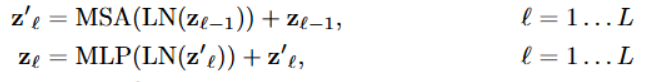


In [ ]:
class Encode(nn.Module):
    """
    Transformer Encoder Block used in Vision Transformer (ViT).

    Args:
        MSA (nn.Module): Multi-head self-attention module constructor.
        MLP (nn.Module): Feedforward MLP block constructor.
        hidden_dim (int): Embedding dimension of the input.
        num_heads (int): Number of attention heads.
        mlp_size (int): Hidden layer size of the MLP.
        mlp_dropout (float): Dropout rate for the MLP.
    """
    def __init__(self,
                MSA: nn.Module,
                MLP: nn.Module,
                
                hidden_dim: int = HYPER_PARAMS['embedding_dim'],
                num_heads: int = HYPER_PARAMS['num_heads'],
                
                mlp_size: int = HYPER_PARAMS['MLP_size'],
                mlp_dropout: float = 0.1):
        super().__init__()

        self.msa = MSA(hidden_dim, num_heads)
        self.mlp = MLP(hidden_dim, mlp_size, dropout=mlp_dropout)
        self.layer_norm = nn.LayerNorm(normalized_shape=hidden_dim)

    def forward(self, x):
        x = self.msa(self.layer_norm(x)) + x  # Attention + Residual
        x = self.mlp(self.layer_norm(x)) + x  # MLP + Residual
        return x


### 3.3 MLP Head

The final classification head for ViT: LayerNorm followed by a linear layer projecting to the number of classes.

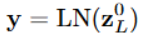


In [32]:
# Classification head for ViT
MLP_Head = nn.Sequential(
    # Normalize the embedding output from the encoder
    nn.LayerNorm(normalized_shape=HYPER_PARAMS['embedding_dim']),
    
    # Project to number of classes for classification
    nn.Linear(
        in_features=HYPER_PARAMS['embedding_dim'],
        out_features=HYPER_PARAMS['num_classes']
    )
)


### 3.4 Assembling the Vision Transformer

We now assemble the full ViT model, matching the structure of `torchvision.models.vit_b_16` to enable use of pretrained weights.

Our implementation uses the custom blocks defined above.


In [33]:
import torch
from torch import nn

class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT-B/16) compatible with torchvision's vit_b_16 pretrained weights.
    
    Args:
        image_size: Input image height/width (assumes square images).
        patch_size: Size of each image patch (e.g. 16).
        in_channels: Number of image channels (e.g. 3 for RGB).
        num_classes: Output classes for classification.
        embedding_dim: Size of patch embeddings (e.g. 768).
        depth: Number of transformer encoder blocks (12 for ViT-B/16).
        num_heads: Number of attention heads (12 for ViT-B/16).
        mlp_size: Hidden size of MLP inside encoder blocks (e.g. 3072).
        dropout: Dropout rate.
    """

    def __init__(self,
                image_size: int = HYPER_PARAMS['height'],
                patch_size: int = HYPER_PARAMS['patch_size'],
                in_channels: int = HYPER_PARAMS['color_channels'],
                num_classes: int = HYPER_PARAMS['num_classes'],
                embedding_dim: int = HYPER_PARAMS['embedding_dim'],
                depth: int = 12,
                num_heads: int = HYPER_PARAMS['num_heads'],
                mlp_size: int = HYPER_PARAMS['MLP_size'],
                dropout: float = 0.1):
        super().__init__()

        # Converts image into a sequence of patch embeddings
        self.patch_embed = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )

        # Learnable [CLS] token that is prepended to the patch sequence
        self.cls_token = class_token

        # Learnable positional embedding added to patch + cls token embeddings
        self.pos_embed = position_embedding

        # Optional dropout after adding positional embeddings
        self.pos_dropout = nn.Dropout(dropout)

        # Stack of transformer encoder blocks
        self.encoder_layers = nn.Sequential(*[
            Encode(
                MSA=MSA,               # Multi-head self-attention block
                MLP=MLP,               # Feed-forward block
                hidden_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=dropout
            )
            for _ in range(depth)
        ])

        # Final normalization after all transformer blocks
        self.encoder_norm = nn.LayerNorm(embedding_dim)

        # Classification head using only the [CLS] token
        self.head = MLP_Head

        # Apply weight initialization as done in the official ViT implementation
        self._init_weights()

    def _init_weights(self):
        """
        Weight initialization to match the pretrained ViT-B/16 weights.
        - Position embeddings and class token initialized with truncated normal.
        - Linear layers are initialized with truncated normal, biases to 0.
        - LayerNorm weights to 1, biases to 0.
        """
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        """
        Forward pass through the model:
        - Convert image to patches and embed them.
        - Add the class token.
        - Add positional encoding.
        - Pass through transformer encoder blocks.
        - Extract the [CLS] token for classification.
        """
        x = self.patch_embed(x)  # Shape: (B, N, D) where N = number of patches, D = embedding_dim

        # Expand class token to batch size and prepend to patch embeddings
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, 1 + N, D)

        # Add positional embeddings and apply dropout
        x = x + self.pos_embed                        # (B, 1 + N, D)
        x = self.pos_dropout(x)

        # Pass through transformer blocks
        x = self.encoder_layers(x)
        x = self.encoder_norm(x)

        # Classification using the [CLS] token (index 0)
        x = self.head(x[:, 0])                        # (B, num_classes)
        return x


# 4. Loading Pretrained Weights from PyTorch ViT-B/16

To accelerate training and leverage state-of-the-art performance, we use pretrained weights from PyTorch's `torchvision.models.vit_b_16`. This allows us to benefit from transfer learning, especially when our dataset is limited or training from scratch is computationally expensive.

---


## 4.1 Model Comparison: Custom ViT vs PyTorch ViT-B/16

Before loading weights, we compare our custom Vision Transformer implementation with PyTorch's official ViT-B/16 to ensure architectural compatibility.

This step is crucial for successful weight transfer and highlights any differences in model structure.


In [2]:
HYPER_PARAMS = {"batch_size": 32, 
                "height": 224, # H
                "width" : 224, # W
                "color_channels": 3, # C
                
                "patch_size": 16, # P
                "number_of_patches": 224*224 // 16**2, # N = H*W/P^2
                "embedding_dim": 768, # D = N*(P^2 *C)
                
                "MLP_size": 3072,
                "num_heads": 12,
                
                "num_classes": 14
}

In [3]:
import torch
import torchvision
from torchinfo import summary

from torchvision.models import vit_b_16
from going_modular.model import VisionTransformer

vit_torch = vit_b_16(weights="DEFAULT")
my_vit = VisionTransformer()

summary(vit_torch, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [4]:
summary(my_vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [1, 3, 224, 224]     [1, 14]              152,064              True
├─PatchEmbedding (patch_embed)           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                 [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (pos_dropout)                  [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (encoder_layers)            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Encode (0)                        [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─LayerNorm (layer_norm)       [1, 197, 768]        [1, 197, 768]        1,536                True
│    │    └─MSA (m

> **Note:** Training a large Vision Transformer from scratch is resource-intensive and time-consuming. For practical purposes, we use PyTorch's pretrained ViT-B/16 and apply transfer learning. Our custom model remains functional and can be trained from scratch if desired.


## 4.2 Fine-Tuning ViT-B/16 for Blood Cell Classification

We fine-tune the pretrained ViT-B/16 model by replacing its classification head with a new one tailored to our number of blood cell classes.

All pretrained layers are frozen except the new head, enabling efficient adaptation to our dataset.


In [5]:
import torchvision
from torchvision.models import vit_b_16
from torch import nn  

# Define a function to create a Vision Transformer (ViT) model for image classification
def create_ViT(embbeding_dim:int = HYPER_PARAMS['embedding_dim'],
                num_classes: int = HYPER_PARAMS['num_classes']):
    """
    Creates a Vision Transformer (ViT-B/16) model with a custom classification head 
    and returns it along with the appropriate image transformations.

    The model uses pretrained weights from torchvision and freezes all layers 
    except for the classification head, which is replaced to match the specified 
    number of output classes.

    Args:
        embbeding_dim (int): Size of patch embeddings 
                            Defaults to HYPER_PARAMS['embedding_dim'].
        num_classes (int): The number of output classes for the classification task. 
                        Defaults to HYPER_PARAMS['num_classes'].

    Returns:
        vit (torchvision.models.VisionTransformer): The modified Vision Transformer model.
        transforms (Callable): The image preprocessing transformations required by the pretrained model.
    """
    
    # Load the default pretrained weights for ViT-B/16
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    
    # Get the corresponding image transforms (normalization, resizing, etc.)
    transforms = weights.transforms()
    
    # Load the ViT-B/16 model with pretrained weights
    vit = vit_b_16(weights="DEFAULT")
    
    # Freeze all parameters so that only the classification head is trainable
    for param in vit.parameters():
        param.requires_grad = False
    
    # Replace the original classification head with a new one for our number of classes
    vit.heads = nn.Sequential(
        nn.Linear(
            in_features=embbeding_dim,  
            out_features=num_classes                  
        )
    )
    
    # Return the modified model and the required image transforms
    return vit, transforms


In [6]:
from torchinfo import summary
vit, vit_trans = create_ViT()

summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 14]              768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [7]:
from pathlib import Path
from going_modular import data_setup

DATA_DIR = Path("Blood cells datasets/")
# create dataloaders with the right transforms
train_dataloader, test_dataloader, train_dataset, test_dataset, class_names = data_setup.create_dataloaders(root=DATA_DIR,
                                                                                                            transform=vit_trans,
                                                                                                            batch_size=32)

train_dataloader_5_percent = data_setup.get_x_percent_dataloader (dataset=train_dataset,
                                                                    percent= 0.05,
                                                                    shuffle=True)

test_dataloader_5_percent = data_setup.get_x_percent_dataloader (dataset=test_dataset,
                                                                    percent= 0.05,
                                                                    shuffle=False)


In [8]:
from going_modular.engine import train

optimizer = torch.optim.Adam(params= vit.parameters(),
                            lr = 1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

vit_results = train(model= vit,
                    train_dataloader= train_dataloader_5_percent,
                    test_dataloader= test_dataloader_5_percent,
                    optimizer= optimizer,
                    loss_fn=loss_fn,
                    device= device)

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/2900 samples
Looked at 384/2900 samples
Looked at 768/2900 samples
Looked at 1152/2900 samples
Looked at 1536/2900 samples
Looked at 1920/2900 samples
Looked at 2304/2900 samples
Looked at 2688/2900 samples


Train loss: 1.79801 | Train accuracy: 44.97%
Test loss: 1.31930 | Test accuracy: 59.50%


Looked at 0/2900 samples
Looked at 384/2900 samples
Looked at 768/2900 samples
Looked at 1152/2900 samples
Looked at 1536/2900 samples
Looked at 1920/2900 samples
Looked at 2304/2900 samples
Looked at 2688/2900 samples


Train loss: 1.15462 | Train accuracy: 66.31%
Test loss: 1.05051 | Test accuracy: 70.18%


Looked at 0/2900 samples
Looked at 384/2900 samples
Looked at 768/2900 samples
Looked at 1152/2900 samples
Looked at 1536/2900 samples
Looked at 1920/2900 samples
Looked at 2304/2900 samples
Looked at 2688/2900 samples


Train loss: 0.93041 | Train accuracy: 72.86%
Test loss: 0.92437 | Test accuracy: 69.21%


Looked at 0/2900 samples
Looked at 384/2900 samples
Looked at 768/2

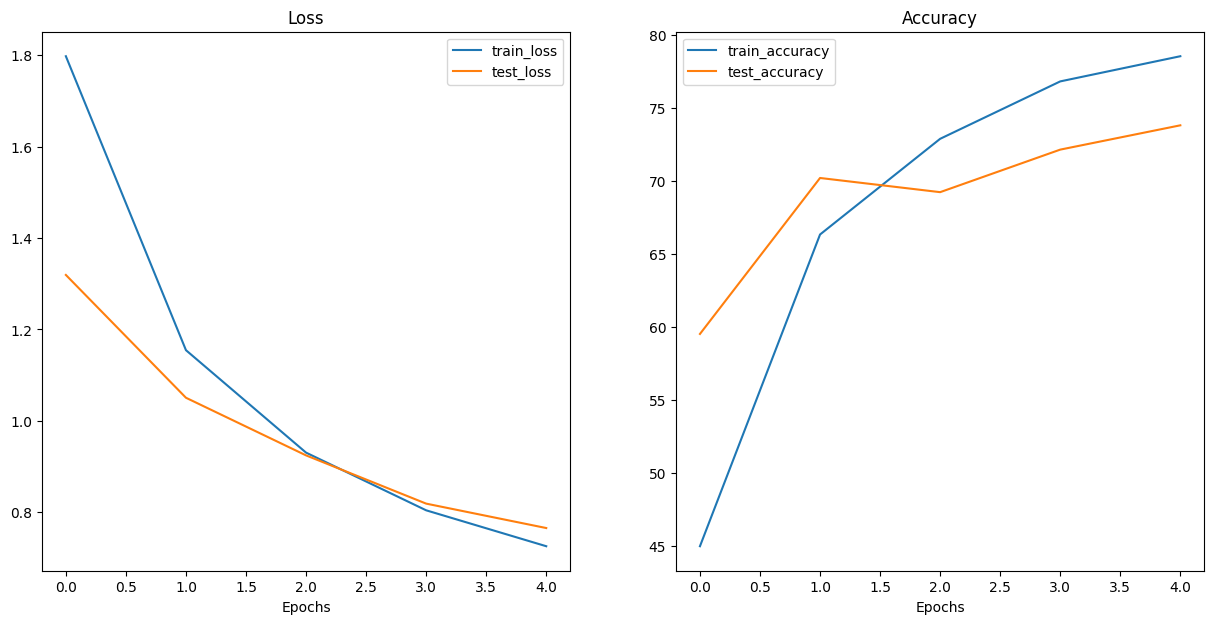

In [9]:
from going_modular.helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

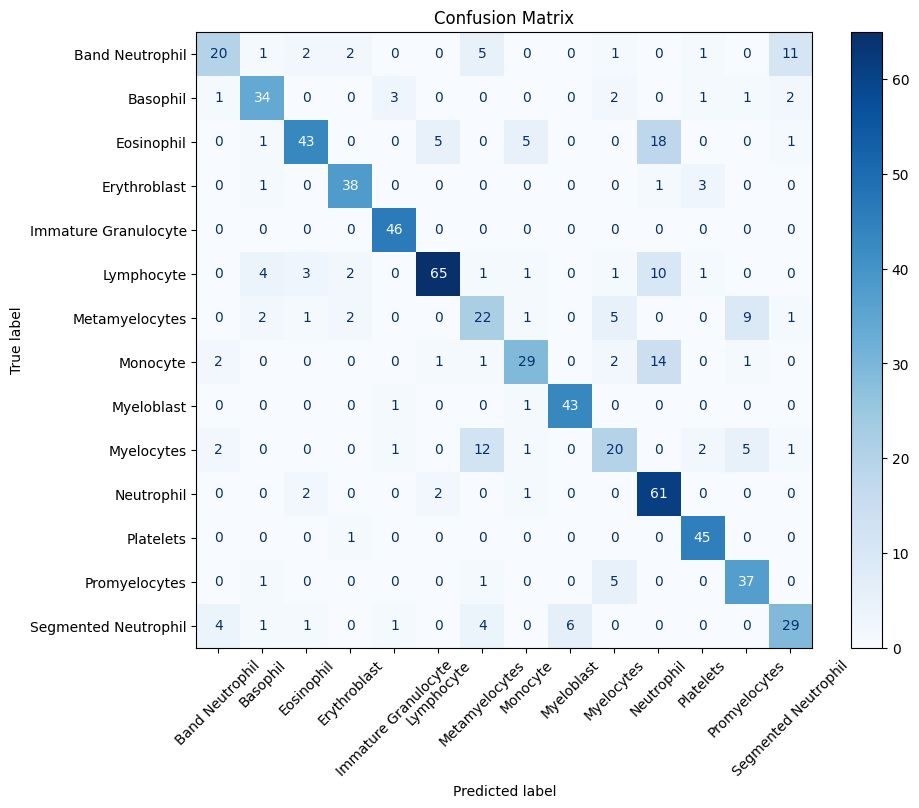

In [12]:
from going_modular import utils
utils.confusion_matrix_and_plot(model=vit,
                                dataloader=test_dataloader_5_percent,
                                class_names=class_names,
                                device=device)

# 5. Final Testing and Full Dataset Evaluation

For comprehensive evaluation and final results, we use the entire dataset in a separate notebook: `final_fine_tuning.ipynb`.

- This ensures robust assessment of model performance on all available data.
- Refer to `final_fine_tuning.ipynb` for the complete fine-tuning and testing workflow.


In [11]:
from going_modular import utils

utils.save_model(vit, "models/", "My_ViT_16b.pth")

[INFO] ✅ Model saved to: models\My_ViT_16b.pth
